In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .35 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = np.random.normal(1, .05, size=n)
phat0 = g*F0/S0

#holdings fiat
h = sts.expon.rvs( loc=10,scale=10, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

In [4]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'population':[n],
    'phi': [phi],
    'invariant': [V0]}

In [5]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'action': {}}

In [6]:
initial_conditions

{'action': {},
 'funds': 35000.0,
 'holdings': array([28.60812685, 13.88618985, 69.57560107, 14.83313704, 12.73194491,
        27.20265489, 19.0694143 , 27.92508473, 11.49639287, 11.73312058,
        18.77500994, 20.73148503, 14.71784798, 17.08877176, 33.9361534 ,
        32.23426253, 12.49404918, 22.87601587, 36.98648553, 10.10171316,
        33.37482248, 12.69034498, 24.25148466, 26.49382242, 29.96849032,
        29.67158883, 29.1595145 , 24.01642016, 22.31733466, 13.54551914,
        13.16646503, 11.3092674 , 10.68541605, 40.19633778, 17.91274556,
        17.33960984, 19.61423364, 16.19353986, 66.46839459, 16.63359868,
        12.65072962, 29.64653694, 25.86365107, 22.72824189, 43.07091657,
        15.21595999, 11.09924412, 36.27496232, 22.28326309, 20.04019149,
        16.01140149, 10.97596983, 11.61062303, 20.8672772 , 16.83358678,
        32.46036624, 15.21629786, 11.61124253, 23.98264886, 19.62206032,
        20.58104973, 20.23397595, 10.05221924, 12.48776319, 53.83415081,
     

In [7]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = 0, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    if delF <1:
        if s['funds'] <1000:
            delF =1
    
    return({'delF':delF})

In [8]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [9]:
def update_prices(params, step, sL, s, _input):
    
    g = params['gains']
    phat = g*s['funds']/s['supply']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [10]:
#change in F (revenue and spending accounted for)
def choose_agent(params, step, sL, s):
    n = params['population']
    rv = np.random.randint(0,n)
    return({'agent':rv})

In [11]:
def agent_action(params, step, sL, s, _input):
    
    a = _input['agent']
    h_a = s['holdings'][a]
    phat_a = s['prices'][a]
    s_a =  s['tokens'][a]
    p = s['spot_price']
    
    if p>phat_a:
        mech = 'burn'
        #solve for burn s.t. p=phat
        #if ha is enough
        amt = 1000 #fill in logic here
        if amt> s_a:
            amt = s_a
        
    else: # p<phat_a:
        mech = 'bond'
        #solve for buy s.t. p=phat
        #if sa is enough
        amt = 1000 #fill in logic here
        if amt> h_a:
            amt = h_a
        
    key = 'action'
    value = {'agent':a, 'mech':mech, 'amt':amt}
    
    return (key, value)

In [12]:
def resolve_action(params, step, sL, s):
    action = s['action']
    a = action['agent']
    amt = action['amt']
    h_a = s['holdings'][a]
    s_a =  s['tokens'][a]
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    
    if action['mech'] == 'bond':
        h_a = h_a-amt
        dS, pbar = mint(amt, R,S, V0, params['kappa'])
        R = R+amt
        S = S+dS
        s_a = s_a+dS
        P = spot_price(R, V0, kappa)
    
    elif action['mech'] == 'burn':
        s_a = s_a-amt
        dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
        R = R-dR
        F = F + params['phi']*dR
        S = S-amt
        h_a = h_a + (1-params['phi'])*dR
        P = spot_price(R, V0, kappa)
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a})

In [13]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    h_a = _input['h_a']
    a = _input['a']
    
    h = s['holdings']
    h[a] = h_a
    
    key = 'holdings'
    value = h
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    s_a = _input['s_a']
    a = _input['a']
    
    tokens = s['tokens']
    tokens[a] = s_a
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [14]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agent
        },
        'variables': { 
            'action': agent_action, 
        }
    },
    {
      'policies': {
          'act': resolve_action,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [15]:
time_periods_per_run = 10000
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [16]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 10000), 'M': {'kappa': 2, 'lambda': 200, 'gains': array([1.05044752, 1.01547431, 0.99090337, 0.96832804, 0.95626203,
       0.9536014 , 1.00699095, 1.00639181, 1.0124076 , 0.97047996,
       1.06225222, 1.00758862, 1.00538574, 0.93287257, 1.02637896,
       0.98499663, 0.89038189, 1.00366084, 1.01243749, 1.03859099,
       1.07318344, 1.0421978 , 1.06402269, 1.09438427, 0.98310885,
       1.0016433 , 0.97706903, 0.97263094, 1.00566796, 0.96094607,
       0.93530768, 1.07514353, 1.00040203, 0.99547888, 0.96499954,
       0.96441107, 0.98604658, 0.98912561, 0.95603367, 0.96398389,
       0.98875942, 0.97281282, 1.00770431, 1.05180774, 1.10182174,
       0.96572804, 0.96536925, 0.99168547, 0.87409068, 1.00436931,
       1.01529099, 0.9998338 , 1.08755008, 0.99226773, 0.91545662,
       0.99147666, 1.03914736, 1.038744  , 1.01549047, 0.9390514 ,
       0.90309398, 1.00024399, 1.00528723, 1.08639874, 0.96645965,
       1.00951948, 1.06787252, 1.019103  , 1.04684384, 

In [17]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [18]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a1b5ddb38>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a1b5ddb38>]


/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS


In [19]:
experiment_index = 0
df = results[experiment_index]['result']

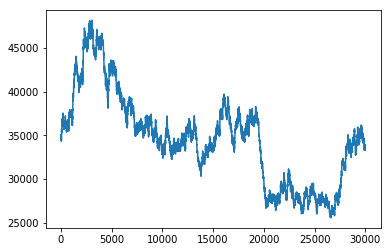

In [20]:
df.funds.plot()

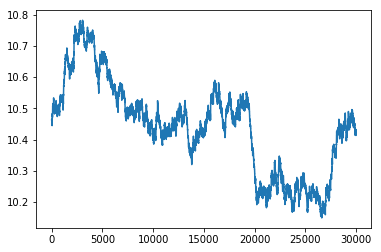

In [21]:
df.funds.apply(np.log).plot()

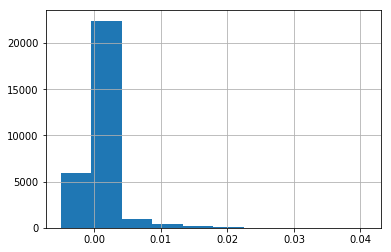

In [22]:
(df.funds.diff()/df.funds).hist()

In [23]:
rdf = df[df.substep == 3].copy()

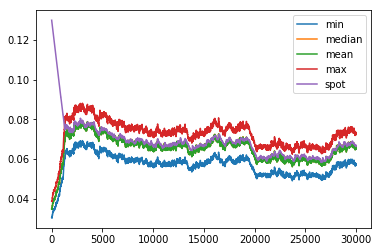

In [24]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','max', 'spot'])

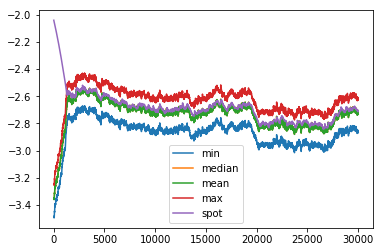

In [25]:
rdf.prices.apply(np.min).apply(np.log).plot()
rdf.prices.apply(np.median).apply(np.log).plot()
rdf.prices.apply(np.mean).apply(np.log).plot()
rdf.prices.apply(np.max).apply(np.log).plot()
rdf.spot_price.apply(np.log).plot()
plt.legend(['min', 'median','mean','max', 'spot'])

In [40]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

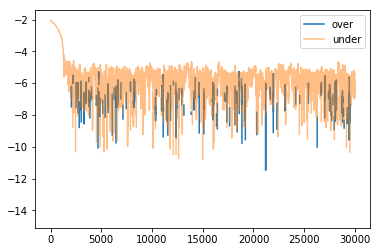

In [55]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [26]:
rdf.action

3               {'agent': 99, 'mech': 'burn', 'amt': 1000}
6               {'agent': 54, 'mech': 'burn', 'amt': 1000}
9               {'agent': 10, 'mech': 'burn', 'amt': 1000}
12              {'agent': 13, 'mech': 'burn', 'amt': 1000}
15              {'agent': 25, 'mech': 'burn', 'amt': 1000}
18              {'agent': 95, 'mech': 'burn', 'amt': 1000}
21              {'agent': 44, 'mech': 'burn', 'amt': 1000}
24              {'agent': 43, 'mech': 'burn', 'amt': 1000}
27              {'agent': 52, 'mech': 'burn', 'amt': 1000}
30              {'agent': 44, 'mech': 'burn', 'amt': 1000}
33              {'agent': 59, 'mech': 'burn', 'amt': 1000}
36               {'agent': 7, 'mech': 'burn', 'amt': 1000}
39              {'agent': 37, 'mech': 'burn', 'amt': 1000}
42              {'agent': 55, 'mech': 'burn', 'amt': 1000}
45              {'agent': 19, 'mech': 'burn', 'amt': 1000}
48              {'agent': 48, 'mech': 'burn', 'amt': 1000}
51              {'agent': 32, 'mech': 'burn', 'amt': 100

In [27]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

In [28]:
rdf['resid'] = rdf.invariant-V0

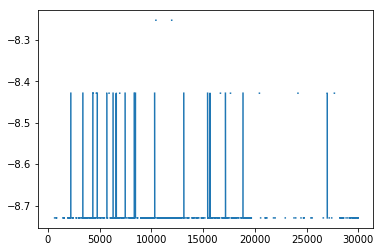

In [29]:
rdf.resid.apply(np.log10).plot()

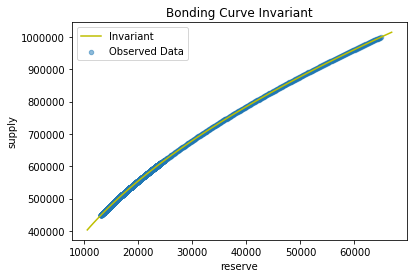

In [56]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

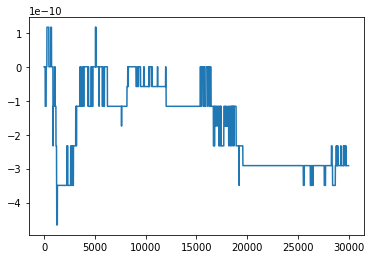

In [30]:
(rdf.tokens.apply(sum)-rdf.supply).plot()

In [31]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [32]:
rdf['gini_h'] = rdf.holdings.apply(gini)

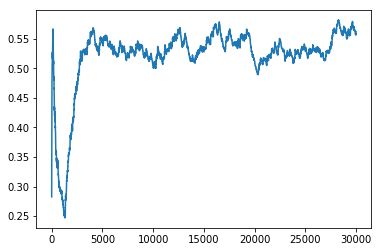

In [33]:
rdf.gini_h.plot()

In [34]:
rdf['gini_s'] = rdf.tokens.apply(gini)

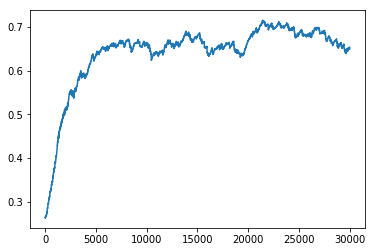

In [35]:
rdf.gini_s.plot()

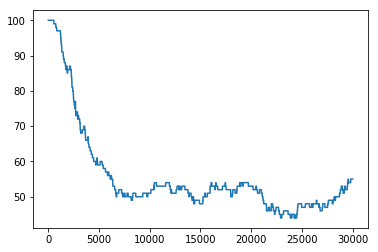

In [36]:
rdf.tokens.apply(np.count_nonzero).plot()

In [37]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [38]:
rdf['gini'] = rdf.asset_value.apply(gini)

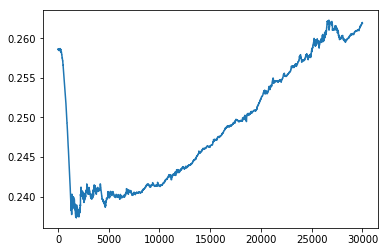

In [39]:
rdf.gini.plot()